In [56]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

import os
import numpy as np
import matplotlib.pyplot as plt

# Global Variables
IMG_SIZE = 224
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 32
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

EPOCHS = 10

In [57]:
def load_images_from_folder(pair_folder):
    image1_path = os.path.join(pair_folder, 'image1.png')
    image2_path = os.path.join(pair_folder, 'image2.png')

    img1 = image.load_img(image1_path, target_size=(IMG_SIZE, IMG_SIZE))
    img2 = image.load_img(image2_path, target_size=(IMG_SIZE, IMG_SIZE))

    img1_array = image.img_to_array(img1)  # Rescale images to [0, 1]
    img2_array = image.img_to_array(img2)

    return img1_array, img2_array

def load_label(label_path):
    label = np.loadtxt(label_path, delimiter=',')
    return label

In [58]:
data_folder = r"../Training Data/UE5 Data"

images_folder = os.path.join(data_folder, "Images")
labels_folder = os.path.join(data_folder, "Labels")

images = []
labels = []

for pair_name in os.listdir(images_folder):
    pair_folder_path = os.path.join(images_folder, pair_name)
    image1, image2 = load_images_from_folder(pair_folder_path)
    images.append((image1, image2))

    label_path = os.path.join(labels_folder, pair_name + ".txt")
    label = load_label(label_path)

    labels.append(label)

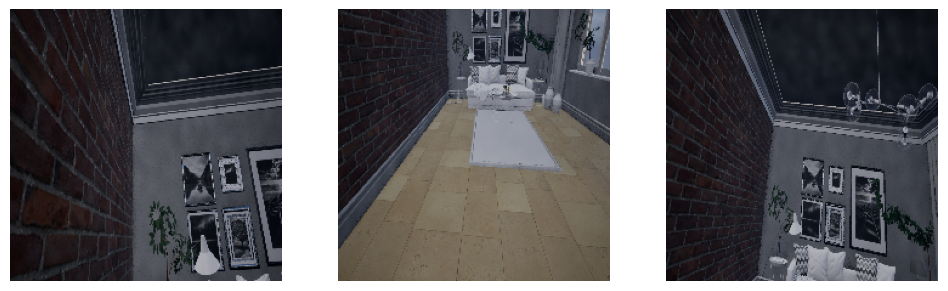

In [59]:
plt.figure(figsize=(12, 12))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    image1 = images[i][0]
    image1 = np.clip(image1, 0, 255).astype(np.uint8)
    
    plt.imshow(image1)
    plt.axis("off")
    
plt.show()

In [60]:
train_images = images[:int(len(images)//1.25)]
train_labels = labels[:int(len(labels)//1.25)]

test_images = images[int(len(images)//1.25):]
test_labels = labels[int(len(labels)//1.25):]

In [61]:
def unpack_tuple(images, label):
    return (images[0], images[1]), label

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.map(unpack_tuple).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.map(unpack_tuple).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [62]:
input_image1 = layers.Input(shape=IMG_SHAPE)
input_image2 = layers.Input(shape=IMG_SHAPE)

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

base_model.trainable = False

x1 = base_model(input_image1)
x2 = base_model(input_image2)

x1 = layers.GlobalAveragePooling2D()(x1)
x2 = layers.GlobalAveragePooling2D()(x2)

concatenated = layers.concatenate([x1, x2], axis=-1)

x = layers.Dense(512, activation='relu')(concatenated)
x = layers.Dense(256, activation='relu')(x)

output = layers.Dense(6)(x)

model = models.Model(inputs=[input_image1, input_image2], outputs=output)

model.compile(loss='mse', optimizer='adam', metrics=['mae', 'accuracy'])

In [63]:
history = model.fit(
  train_dataset,
  epochs=EPOCHS)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.4013 - loss: 90.8285 - mae: 5.3488
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6478 - loss: 43.8854 - mae: 3.7683
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6457 - loss: 44.0969 - mae: 4.0432
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6912 - loss: 39.2640 - mae: 3.6691
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6465 - loss: 31.3664 - mae: 3.3386
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6439 - loss: 30.6255 - mae: 3.2586
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6875 - loss: 27.8866 - mae: 3.0773
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6370 - loss: 23.6854 - mae: 2.9836
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6504 - loss: 22.2225 - mae: 2.8440
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7145 - loss: 17.5034 - mae: 2.5803


2/2 - 0s - 57ms/step - accuracy: 0.6750 - loss: 47.8581 - mae: 3.8637
Accuracy: 67.5000011920929%


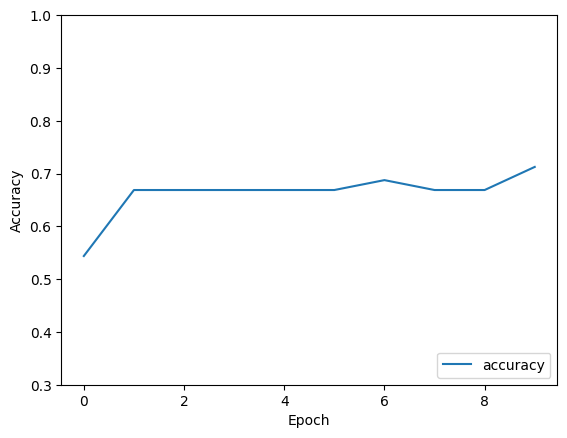

In [65]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

test_loss, mae, test_acc = model.evaluate(test_dataset, verbose=2)
print("Accuracy:", str(test_acc * 100) + "%")